### Twitter sentiment analysis around big tech earnings

Steps taken in the analysis: 
- Data transformation and feature engeneering 
- Data processing and text cleaning
- Sentiment Analysis 
- Lagging Sentiment

Merge sentiment data with stock data
- New feature engeneering
- Exporting final data set 

In [90]:
import pandas as pd
import string 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from stop_words import get_stop_words
stop_words = list(get_stop_words('en'))
import matplotlib.ticker as tick
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import clear_output
clear_output()
import nltk
import re
import numpy as np
nltk.download('punkt')
from textblob import TextBlob
from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ksenia_semina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


1. Twitter Data import

In [72]:
#Importing the scarped twitter data
df = pd.read_csv('Raw Tweeter Data Final .csv') 
df

,Company,Tweet Id,Date,Follower Count,Account Verified,Favorite Count,Retweets,Tweet Text
0,Amazon,1.449900e+18,10/18/21,371,False,0,29,b'RT @JennaEllisEsq: Thanks to the @Apple geni...
1,Amazon,1.449900e+18,10/18/21,1917,False,0,5964,b'RT @ThereGoesTonio: Apple Watch: \xe2\x80\x9...
2,Amazon,1.449900e+18,10/18/21,127,False,0,0,b'@dan_abramov I miss the glowing Apple'
3,Amazon,1.449900e+18,10/18/21,1157,False,0,9,b'RT @keekeexbabyy: She calls me Apple cause t...
4,Amazon,1.449900e+18,10/18/21,72,False,0,5964,b'RT @ThereGoesTonio: Apple Watch: \xe2\x80\x9...
...,...,...,...,...,...,...,...,...
105354,Facebook,1.459760e+18,11/14/21,12876,False,0,112,b'RT @amyklobuchar: I have a bipartisan bill t...
105355,Facebook,1.459760e+18,11/14/21,200,False,1,0,"b""African newspaper 'The Continent' reports #F..."
105356,Facebook,1.459760e+18,11/14/21,71,False,0,996,"b""RT @WORLDMUSICAWARD: #TWICE's #Scientist is ..."
105357,Facebook,1.459760e+18,11/14/21,157,False,0,2520,"b""RT @WORLDMUSICAWARD: #BLACKPINK's #LISA beco..."


2. Normalizing data and New feature engeneering 
- Is the account verified or not? -> create a new binary variable
- Scaling Followers, Favourites and Retweets 
- Creating a new variable that represents the weighted score between number of Followers, Favourites and Retweets

Because min-max scaling resulted in too many values around 0, I am using a different method called scale and clip. 

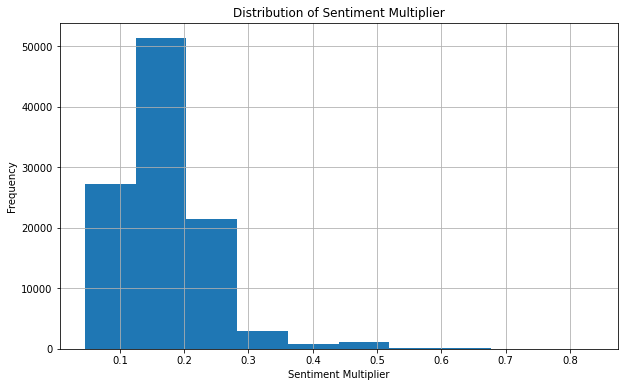

In [77]:
# define a function to perform scaling and clipping
def scale_and_clip(x, min_val, max_val):
    return np.log(x - min_val + 2) / np.log(max_val - min_val + 2)

# scale and clip each feature
df['Follower Count Scaled'] = df['Follower Count '].apply(scale_and_clip, args=(df['Follower Count '].min(), df['Follower Count '].max()))
df['Favorite Count Scaled'] = df['Favorite Count'].apply(scale_and_clip, args=(df['Favorite Count'].min(), df['Favorite Count'].max()))
df['Retweets Scaled'] = df['Retweets'].apply(scale_and_clip, args=(df['Retweets'].min(), df['Retweets'].max()))

# convert Account Verified to a binary number
df['Account Verified Number'] = df['Account Verified'].astype(int)

# calculate the weighted average
df['Sentiment Multiplier'] = df[['Follower Count Scaled', 'Favorite Count Scaled', 'Retweets Scaled', 'Account Verified Number']].mean(axis=1)

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram with 20 bins
df['Sentiment Multiplier'].hist(bins=10)

# Add axis labels and title
plt.xlabel('Sentiment Multiplier')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Multiplier')
# Show the plot
plt.show()


3. Cleaning and pre processing text from tweets

In [78]:
# define a set of custom stop words
custom_stopwords = set(['b', 'rt', 'brt', 'illegallynnxe2x80x9carizona', 'invexe2x80xa6', 'xf0x9fxa4xa3xf0x9fxa4xa3', 'xe2', 'x80', 'x9carizona', 'inve', 'xa6', 'n', 't', 'co', 'nhttps'])

# define functions for text cleaning
def clean_text(text):
    text = re.sub(r'https?:\/\/\S+', '', text) # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove special characters
    text = text.strip() # Remove leading/trailing whitespaces
    text = re.sub(r'RT @\w+:', '', text) # Remove RT and username
    text = text.lower() # Convert to lowercase
    #text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    return text

# get rid of the stop words 
def remove_stopwords(text):
    tokens = nltk.word_tokenize(text.lower()) # tokenize and convert to lower case
    tokens = [token for token in tokens if token not in stop_words] # remove stop words
    tokens = [token for token in tokens if token not in custom_stopwords] # remove custom stop words
    return ' '.join(tokens)

# apply text cleaning and tokenization
df['Clean Text'] = df['Tweet Text'].apply(clean_text)
df['Final Clean'] = df['Clean Text'].apply(remove_stopwords)


df.head(3)

,Company,Tweet Id,Date,Follower Count,Account Verified,Favorite Count,Retweets,Tweet Text,Follower Count Scaled,Favorite Count Scaled,Retweets Scaled,Account Verified Number,Sentiment Multiplier,Clean Text,Final Clean
0,Amazon,1.449900e+18,10/18/21,371,False,0,29,b'RT @JennaEllisEsq: Thanks to the @Apple geni...,0.324570,0.091062,0.267729,0,0.170840,brt jennaellisesq thanks to the apple genius i...,jennaellisesq thanks apple genius nyc told get...
1,Amazon,1.449900e+18,10/18/21,1917,False,0,5964,b'RT @ThereGoesTonio: Apple Watch: \xe2\x80\x9...,0.414350,0.091062,0.677810,0,0.295806,brt theregoestonio apple watch xe2x80x9cstand ...,theregoestonio apple watch xe2x80x9cstand tf u...
2,Amazon,1.449900e+18,10/18/21,127,False,0,0,b'@dan_abramov I miss the glowing Apple',0.266373,0.091062,0.054041,0,0.102869,bdanabramov i miss the glowing apple,bdanabramov miss glowing apple


4. Sentiment Analysis
- Compute sentiment 
- Look at destribution of the sentiment scores and categories
- Compute subjectivity and polarity

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a rule-based sentiment analysis tool that is specifically designed to analyze the sentiment of social media texts. As we are looking at Twitter data is would be a more appropriate sentiment python package to use. 

In [79]:
#Sentiment Analysis

vader = SentimentIntensityAnalyzer()

#Sentiment Analyzer function to get neutral, negative, positive and compound score for each row in the datadrame
def vader_scores(text, category):
  return vader.polarity_scores(text).get(category)

In [80]:

#Applying the above function to the dataframe 
#Compound score is the overall score that is based on the neg, neu and pos scores from vader analysis
#We are mostly interested in the compound score for our analysis

df["Negative_Score"] = df.apply(lambda row : vader_scores(df["Final Clean"][row.name], "neg"),axis=1)
df["Neutral_Score"] = df.apply(lambda row : vader_scores(df["Final Clean"][row.name], "neu"),axis=1)
df["Positive_Score"] = df.apply(lambda row : vader_scores(df["Final Clean"][row.name], "pos"),axis=1)
df["Compound_Score"] = df.apply(lambda row : vader_scores(df["Final Clean"][row.name], "compound"),axis=1)

#Creating a new variable to show if the tween was positive, nagative or neutral based on its compound score
df['Sentimet_Type'] = df['Compound_Score'].map(lambda x: 'Positive'  if (x > 0) else ('Negative' if (x < 0) else 'Neutral'))



In [81]:
#Applying min max scaled values and multiplying them by the sentiment score to get a weighed score 
df['Sentiment Score Scaled'] = df['Sentiment Multiplier'] * df['Compound_Score'] 
df.head(3)

,Company,Tweet Id,Date,Follower Count,Account Verified,Favorite Count,Retweets,Tweet Text,Follower Count Scaled,Favorite Count Scaled,...,Account Verified Number,Sentiment Multiplier,Clean Text,Final Clean,Negative_Score,Neutral_Score,Positive_Score,Compound_Score,Sentimet_Type,Sentiment Score Scaled
0,Amazon,1.449900e+18,10/18/21,371,False,0,29,b'RT @JennaEllisEsq: Thanks to the @Apple geni...,0.324570,0.091062,...,0,0.170840,brt jennaellisesq thanks to the apple genius i...,jennaellisesq thanks apple genius nyc told get...,0.000,0.805,0.195,0.4404,Positive,0.075238
1,Amazon,1.449900e+18,10/18/21,1917,False,0,5964,b'RT @ThereGoesTonio: Apple Watch: \xe2\x80\x9...,0.414350,0.091062,...,0,0.295806,brt theregoestonio apple watch xe2x80x9cstand ...,theregoestonio apple watch xe2x80x9cstand tf u...,0.000,1.000,0.000,0.0000,Neutral,0.000000
2,Amazon,1.449900e+18,10/18/21,127,False,0,0,b'@dan_abramov I miss the glowing Apple',0.266373,0.091062,...,0,0.102869,bdanabramov i miss the glowing apple,bdanabramov miss glowing apple,0.348,0.652,0.000,-0.1531,Negative,-0.015749


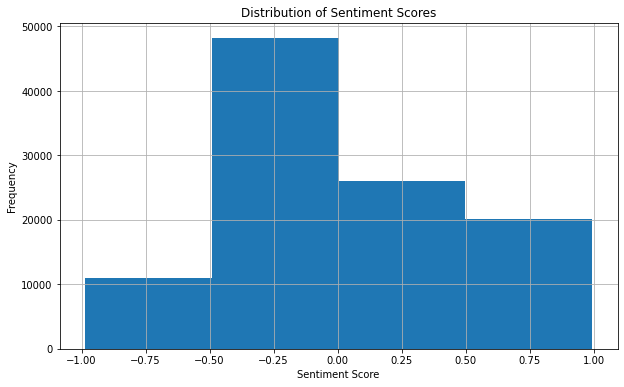

In [82]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the histogram with 20 bins
df['Compound_Score'].hist(bins=4)

# Add axis labels and title
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')

# Show the plot
plt.show()

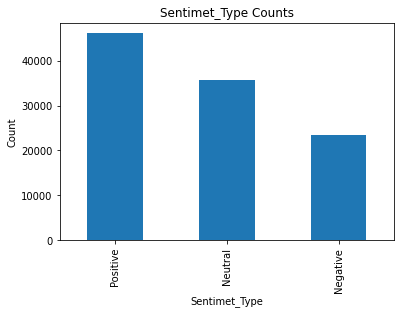

In [83]:
# get value counts of 'Fruit' column
fruit_counts = df['Sentimet_Type'].value_counts()

# create bar graph
fruit_counts.plot.bar()

# set axis labels and title
plt.xlabel('Sentimet_Type')
plt.ylabel('Count')
plt.title('Sentimet_Type Counts')
plt.show()

Adding Subjectivity and Polarity Features

In [84]:
#load the descriptions into textblob to get polarity and subjectivity of a tweet
desc_blob = [TextBlob(desc) for desc in df['Final Clean']]

#add the sentiment metrics to the dataframe
df['Polarity'] = [b.sentiment.polarity for b in desc_blob]
df['Subjectivity'] = [b.sentiment.subjectivity for b in desc_blob]
#show dataframe
df.head(3)

,Company,Tweet Id,Date,Follower Count,Account Verified,Favorite Count,Retweets,Tweet Text,Follower Count Scaled,Favorite Count Scaled,...,Clean Text,Final Clean,Negative_Score,Neutral_Score,Positive_Score,Compound_Score,Sentimet_Type,Sentiment Score Scaled,Polarity,Subjectivity
0,Amazon,1.449900e+18,10/18/21,371,False,0,29,b'RT @JennaEllisEsq: Thanks to the @Apple geni...,0.324570,0.091062,...,brt jennaellisesq thanks to the apple genius i...,jennaellisesq thanks apple genius nyc told get...,0.000,0.805,0.195,0.4404,Positive,0.075238,0.066667,0.092308
1,Amazon,1.449900e+18,10/18/21,1917,False,0,5964,b'RT @ThereGoesTonio: Apple Watch: \xe2\x80\x9...,0.414350,0.091062,...,brt theregoestonio apple watch xe2x80x9cstand ...,theregoestonio apple watch xe2x80x9cstand tf u...,0.000,1.000,0.000,0.0000,Neutral,0.000000,0.000000,0.000000
2,Amazon,1.449900e+18,10/18/21,127,False,0,0,b'@dan_abramov I miss the glowing Apple',0.266373,0.091062,...,bdanabramov i miss the glowing apple,bdanabramov miss glowing apple,0.348,0.652,0.000,-0.1531,Negative,-0.015749,0.000000,0.000000


5. Lagging Sentiment 

In [147]:
#Creating a lagged varible 

#First create a daily sentiment average for each company 

df1 = df.groupby(['Company', 'Date'], as_index=False).agg({'Sentiment Score Scaled': 'mean'})

# Now we want to create a lag variable for each company
df1 = df1.set_index(["Date", "Company"]) # index

Lag1 = df1.groupby(level="Company").shift(-1)
df1 = df1.join(Lag1.rename(columns=lambda x: x+"_lag1"))


  
#Now that we have the average value we need to map it out back to the original dataframe
df1 = pd.merge(df, df1, how="inner", on=["Company", "Date"])
df1.head(3)

,Company,Tweet Id,Date,Follower Count,Account Verified,Favorite Count,Retweets,Tweet Text,Follower Count Scaled,Favorite Count Scaled,...,Negative_Score,Neutral_Score,Positive_Score,Compound_Score,Sentimet_Type,Sentiment Score Scaled_x,Polarity,Subjectivity,Sentiment Score Scaled_y,Sentiment Score Scaled_lag1
0,Amazon,1.449900e+18,10/18/21,371,False,0,29,b'RT @JennaEllisEsq: Thanks to the @Apple geni...,0.324570,0.091062,...,0.000,0.805,0.195,0.4404,Positive,0.075238,0.066667,0.092308,0.012608,-0.006619
1,Amazon,1.449900e+18,10/18/21,1917,False,0,5964,b'RT @ThereGoesTonio: Apple Watch: \xe2\x80\x9...,0.414350,0.091062,...,0.000,1.000,0.000,0.0000,Neutral,0.000000,0.000000,0.000000,0.012608,-0.006619
2,Amazon,1.449900e+18,10/18/21,127,False,0,0,b'@dan_abramov I miss the glowing Apple',0.266373,0.091062,...,0.348,0.652,0.000,-0.1531,Negative,-0.015749,0.000000,0.000000,0.012608,-0.006619


5. Combining sentiment analysis data with stock price

In [148]:
#Importing Stock Data for companies
stock = pd.read_csv('Stock Index Final.csv')
stock


#importing DJI and S&P500 data
stock2 = pd.read_csv('Market Stock.csv')
#Merging the two lists together on date and company name 
merged = pd.merge(df1,stock,how='inner',left_on=['Company','Date'],right_on=['Company','Date'])
data = pd.concat([merged, stock2])


#def to calculate if the stock price increased or decreased on that day 
data['Change'] = data["Close"] - data["Open"]

# creating a new variable to see if there was a positive or negative change in stock price
def change(x):
    if x > 0: 
        return 1 
    else: 
        return 0
        
data["New_Change"] = data["Change"].apply(change)
data.head(3)


,Company,Tweet Id,Date,Follower Count,Account Verified,Favorite Count,Retweets,Tweet Text,Follower Count Scaled,Favorite Count Scaled,...,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,Change,New_Change
0,Amazon,1.449900e+18,10/18/21,371.0,False,0.0,29.0,b'RT @JennaEllisEsq: Thanks to the @Apple geni...,0.324570,0.091062,...,3388.360107,3449.169922,3385.100098,3446.73999,3174100,0.0,0,AMZN,58.379883,1
1,Amazon,1.449900e+18,10/18/21,1917.0,False,0.0,5964.0,b'RT @ThereGoesTonio: Apple Watch: \xe2\x80\x9...,0.414350,0.091062,...,3388.360107,3449.169922,3385.100098,3446.73999,3174100,0.0,0,AMZN,58.379883,1
2,Amazon,1.449900e+18,10/18/21,127.0,False,0.0,0.0,b'@dan_abramov I miss the glowing Apple',0.266373,0.091062,...,3388.360107,3449.169922,3385.100098,3446.73999,3174100,0.0,0,AMZN,58.379883,1


In [150]:
# calculate the correlation between Close and Sentiment Score Scaled_lag
corr = data['Close'].corr(data['Sentiment Score Scaled_lag1'])
corr1 = data['Close'].corr(data['Sentiment Score Scaled_y'])
print(f' The correlation between the Closing price and Scaled Lagged variable is {corr}')
print(f' The lag improved the correlation, initially it was {corr1}')


 The correlation between the Closing price and Scaled Lagged variable is 0.40339289204842393
 The lag improved the correlation, initially it was 0.34744032902999417


Export the data for futher correaltion and linear regression analysis

In [123]:
#Exporing the data
#data.to_csv("Tweeter_Exploratory_Data.csv")
data.to_csv("Twitter_Exploratory_Data_Lagged.csv")